### Подгружаем данные о котирвках Google с yfinance с 2015 года. Есть следующая информация в разрезе даты по каждой акции:
### -Цена открытия/закрытия
### -Цена верхняя/нижняя
### -Объем транзакций

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Concatenate
import random
import yfinance as yc
from datetime import datetime, timedelta
import pandas as pd
import yfinance as yf
from datetime import date

start_date="2015-01-01"
end_date=date.today() + timedelta(days=1)

data = yf.download(["GOOG"], start=start_date, end=end_date)
data = data.reset_index()

new_columns = []
for col in data.columns:
    if col[0] == 'Date' and col[1] == '':
        new_columns.append('date')
    else:
        new_columns.append(f"{col[1].lower()}_{col[0].lower()}")



data.columns = new_columns
data['date'] = pd.to_datetime(data['date']).dt.date
print(len(data))
data.tail(1)

/tmp/ipython-input-958253319.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(["GOOG"], start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

2714


,date,goog_close,goog_high,goog_low,goog_open,goog_volume
2713,2025-10-16,252.429901,257.579987,251.509995,252.470001,11078461


### Чтобы что то предсказывать, надо знать, что предсказывать. Выбрали ср. величину верхней и нижней границы в сутках

In [2]:
data['avg_price_goog'] = (data['goog_high'] + data['goog_low']) / 2
data

display(data.tail())

,date,goog_close,goog_high,goog_low,goog_open,goog_volume,avg_price_goog
2709,2025-10-10,237.490005,244.839996,236.684998,242.160004,22449100,240.762497
2710,2025-10-13,244.639999,244.990005,240.750000,241.029999,12465000,242.870003
2711,2025-10-14,246.190002,248.024994,241.177994,241.755005,17705400,244.601494
2712,2025-10-15,251.710007,252.759995,246.789993,248.085007,16034900,249.774994
2713,2025-10-16,252.429901,257.579987,251.509995,252.470001,11078461,254.544991


In [3]:
import pandas as pd
data = data.sort_values('date').reset_index(drop=True)

data['spread'] = data['avg_price_goog'].diff()

data['spread'] = data['avg_price_goog'].diff(periods=1)
data['spread'] = data['spread'].fillna(1)
data['spread'] = data['spread'].abs()
data['volatility'] = data['goog_high'] - data['goog_low']


In [4]:
len(data), len(data['date'].unique())

(2714, 2714)

### Объединим 2 датафрейма: датафрейм по новостям и котировок



In [5]:
calc_sentiment_news_df = pd.read_csv('./csv/news_google_calc_sentiment.csv')[['goog_publishedat',	'goog_sentiment',	'goog_sentiment_score']]

STOCKS = ["GOOG"]
tmp_df = data.copy()
tmp_df['date'] = pd.to_datetime(tmp_df['date']).dt.date
calc_sentiment_news_df['goog_publishedat'] = pd.to_datetime(calc_sentiment_news_df['goog_publishedat']).dt.date

tmp_df = tmp_df.merge(calc_sentiment_news_df, left_on='date', right_on=f'goog_publishedat', how='inner')


tmp_df[f'goog_sentiment'] = tmp_df[f'goog_sentiment'].fillna("neutral")
tmp_df[f'goog_sentiment_score'] = tmp_df[f'goog_sentiment_score'].fillna(0)

tmp_df = tmp_df.drop([f"goog_publishedat"], axis=1)

### Построим матрицу кореляции признаков

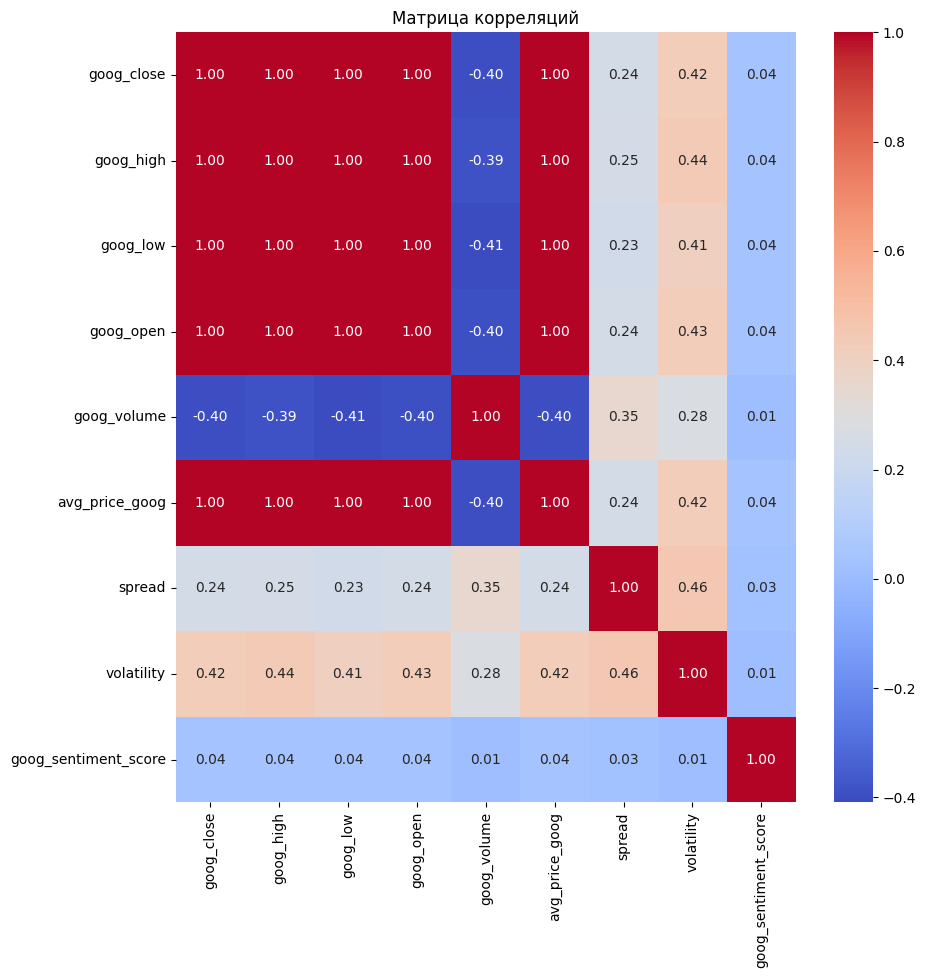

In [6]:
numeric_df = tmp_df.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Матрица корреляций')
plt.show()

In [7]:
data = tmp_df.copy()

In [8]:
tmp_df[tmp_df['goog_sentiment_score'] < 0]

,date,goog_close,goog_high,goog_low,goog_open,goog_volume,avg_price_goog,spread,volatility,goog_sentiment,goog_sentiment_score


In [9]:
data = tmp_df.copy()

In [10]:
print("Детальная статистика по NaN:")
for column in tmp_df.columns:
    nan_count = tmp_df[column].isna().sum()
    nan_percent = (nan_count / len(tmp_df)) * 100
    print(f"{column}: {nan_count} NaN ({nan_percent:.2f}%)")


Детальная статистика по NaN:
date: 0 NaN (0.00%)
goog_close: 0 NaN (0.00%)
goog_high: 0 NaN (0.00%)
goog_low: 0 NaN (0.00%)
goog_open: 0 NaN (0.00%)
goog_volume: 0 NaN (0.00%)
avg_price_goog: 0 NaN (0.00%)
spread: 0 NaN (0.00%)
volatility: 0 NaN (0.00%)
goog_sentiment: 0 NaN (0.00%)
goog_sentiment_score: 0 NaN (0.00%)


### 1. Мы рассчитываем новый скор на основе рассчитанного скора по тональности и на останове давности дат публикации статьи, по формуле: скор_тональности * exp(-lambda * кол-во_пройденных_дней_со_дня_выдачи_инфы_по_акции).
### В случае, если скор по тональности было равно 0, что значит, так посчитал finbert, либо просто не было статьи на этот день по организации, то расчет значения в записи производится по формуле:
### exp(-lambda * кол-во_пройденных_дней_со_дня_выдачи_инфы_по_акции)
### 2. Умножаем рассчитанный скор на -1, в записях, где категория тональности negative. Теперь диазпазон значений [-1;1]
### 3. Считаем среднее значение рассчитанного скора в разрезе даты
 в случае если статьи не было в какую то дату, проставляется скор, рас

In [11]:
tmp_df.head(1)

,date,goog_close,goog_high,goog_low,goog_open,goog_volume,avg_price_goog,spread,volatility,goog_sentiment,goog_sentiment_score
0,2020-02-11,74.926758,75.961675,74.770229,75.076732,26892000,75.365952,1.277463,1.191447,neutral,0.0


In [12]:
from datetime import datetime
from datetime import date

tmp_df = data.copy()

def decay_weight(new_date, target_date, half_life=1.0):
    days_diff = (target_date - new_date).days
    return 0.5 ** (days_diff / half_life)

stocks = ["GOOG"]

today = pd.Timestamp.today()


tmp_df["date"] = pd.to_datetime(tmp_df["date"])
tmp_df["age_days"] = (today - tmp_df["date"]).dt.days

lambda_ = 0.005

for stock in STOCKS:
    tmp_df[f"{stock.lower()}_sentiment_score"] = np.where(
        tmp_df[f"{stock.lower()}_sentiment_score"] == 0,
        np.exp(-lambda_ * tmp_df["age_days"]),
        tmp_df[f"{stock.lower()}_sentiment_score"] * np.exp(-lambda_ * tmp_df["age_days"])
    )
    tmp_df[f"{stock.lower()}_sentiment_score"] = tmp_df.apply(
        lambda row: -row[f"{stock.lower()}_sentiment_score"] if row[f"{stock.lower()}_sentiment"] == "negative" else row[f"{stock.lower()}_sentiment_score"],
        axis=1
    )
    tmp_df[f"{stock.lower()}_average_score"] = tmp_df.groupby("date")[f"{stock.lower()}_sentiment_score"].transform(lambda x: x[x != 0.0].mean())

tmp_df.tail(100)


,date,goog_close,goog_high,goog_low,goog_open,goog_volume,avg_price_goog,spread,volatility,goog_sentiment,goog_sentiment_score,age_days,goog_average_score
6724,2025-09-18,252.330002,254.139999,250.110001,251.860001,21166400,252.125000,2.860001,4.029999,neutral,0.869358,28,0.857331
6725,2025-09-18,252.330002,254.139999,250.110001,251.860001,21166400,252.125000,2.860001,4.029999,positive,0.809224,28,0.857331
6726,2025-09-18,252.330002,254.139999,250.110001,251.860001,21166400,252.125000,2.860001,4.029999,neutral,0.869358,28,0.857331
6727,2025-09-18,252.330002,254.139999,250.110001,251.860001,21166400,252.125000,2.860001,4.029999,neutral,0.869358,28,0.857331
6728,2025-09-18,252.330002,254.139999,250.110001,251.860001,21166400,252.125000,2.860001,4.029999,neutral,0.869358,28,0.857331
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6819,2025-10-15,251.710007,252.759995,246.789993,248.085007,16034900,249.774994,5.173500,5.970001,neutral,0.995012,1,0.596805
6820,2025-10-15,251.710007,252.759995,246.789993,248.085007,16034900,249.774994,5.173500,5.970001,negative,-0.995009,1,0.596805
6821,2025-10-15,251.710007,252.759995,246.789993,248.085007,16034900,249.774994,5.173500,5.970001,positive,0.993995,1,0.596805
6822,2025-10-15,251.710007,252.759995,246.789993,248.085007,16034900,249.774994,5.173500,5.970001,neutral,0.995012,1,0.596805


### Удаляем колонки и избавляемся от дублей, приходим к количеству записей, которое было при чтение из yfinance(датафрейм по котировкам). Дублирование происходило в связи с тем, что количество новостей по организации могло быть несколько штук на день, поэтому мы нашли среднюю и избавиляемся от дублей в следующей ячейке

In [13]:
tmp_df.columns

Index(['date', 'goog_close', 'goog_high', 'goog_low', 'goog_open',
       'goog_volume', 'avg_price_goog', 'spread', 'volatility',
       'goog_sentiment', 'goog_sentiment_score', 'age_days',
       'goog_average_score'],
      dtype='object')

In [14]:
tmp_df = tmp_df.drop(columns=['goog_sentiment',	'goog_sentiment_score',	'age_days'])
tmp_df=tmp_df.drop_duplicates()

In [15]:
data = tmp_df.copy()

### Ниже дефолт проверки на уникальность и Nan

In [16]:
len(tmp_df['date'].unique()), len(tmp_df)

(1418, 1418)

In [17]:
duplicates = tmp_df['date'][tmp_df['date'].duplicated(keep=False)]
print(f"Найдено дубликатов: {len(duplicates)}")
print(duplicates)

Найдено дубликатов: 0
Series([], Name: date, dtype: datetime64[ns])


In [18]:
print("Детальная статистика по NaN:")
for column in tmp_df.columns:
    nan_count = tmp_df[column].isna().sum()
    nan_percent = (nan_count / len(tmp_df)) * 100
    print(f"{column}: {nan_count} NaN ({nan_percent:.2f}%)")


Детальная статистика по NaN:
date: 0 NaN (0.00%)
goog_close: 0 NaN (0.00%)
goog_high: 0 NaN (0.00%)
goog_low: 0 NaN (0.00%)
goog_open: 0 NaN (0.00%)
goog_volume: 0 NaN (0.00%)
avg_price_goog: 0 NaN (0.00%)
spread: 0 NaN (0.00%)
volatility: 0 NaN (0.00%)
goog_average_score: 0 NaN (0.00%)


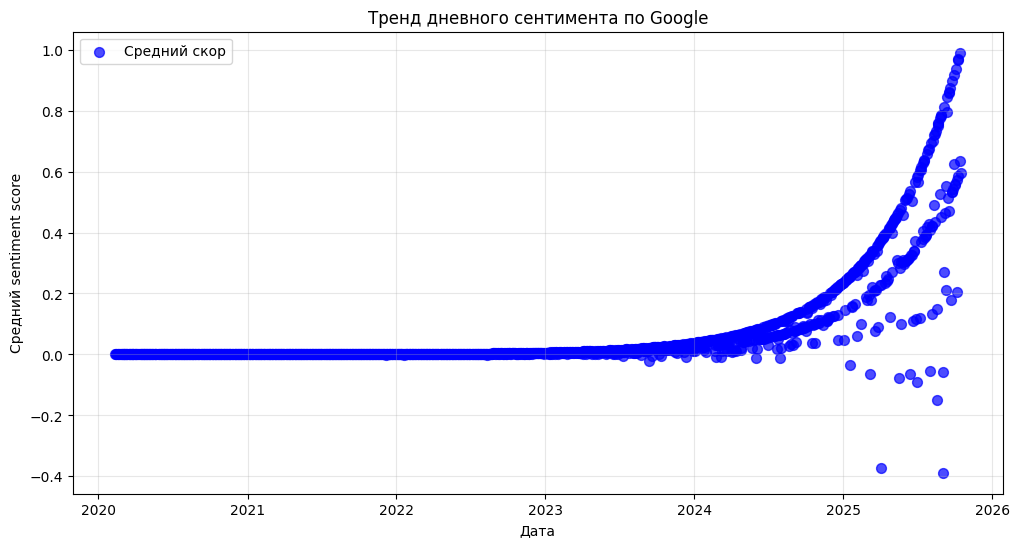

In [19]:
import matplotlib.pyplot as plt

tmp_df['date'] = pd.to_datetime(tmp_df['date'])

daily_sentiment = tmp_df.groupby('date')['goog_average_score'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.scatter(daily_sentiment['date'], daily_sentiment['goog_average_score'],
           alpha=0.7, s=50, color='blue', label='Средний скор')

plt.title('Тренд дневного сентимента по Google')
plt.xlabel('Дата')
plt.ylabel('Средний sentiment score')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

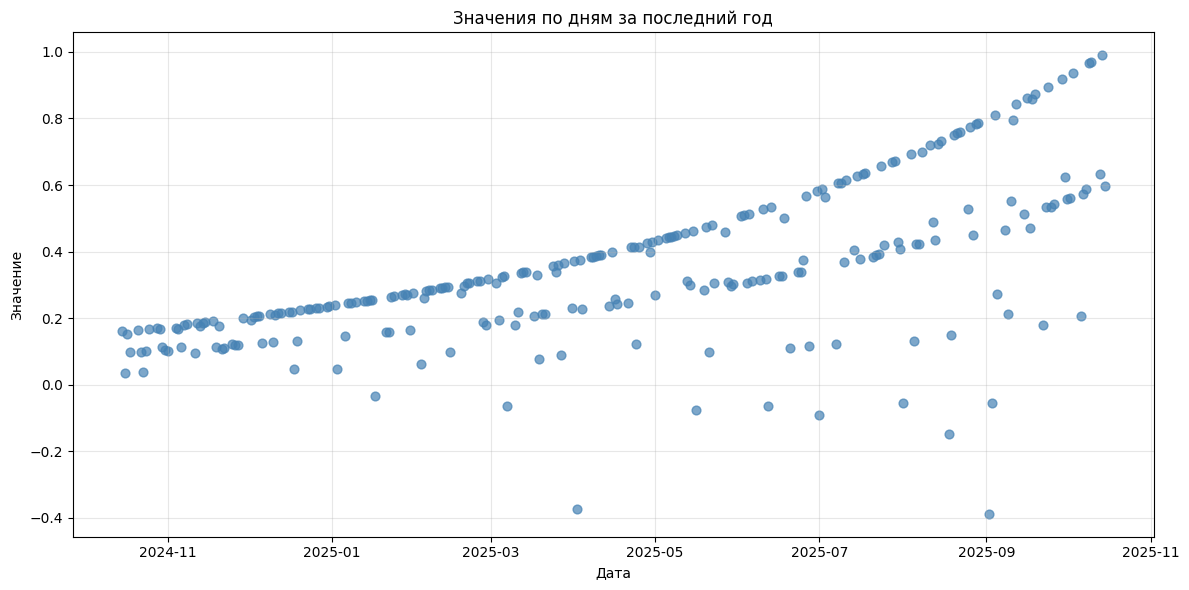

In [20]:
df = tmp_df.copy().set_index('date')

последний_год = df.loc[df.index >= (df.index.max() - pd.Timedelta(days=365))]

дневные = последний_год.resample('D').mean()

plt.figure(figsize=(12, 6))
plt.scatter(дневные.index, дневные['goog_average_score'],
           color='steelblue', s=40, alpha=0.7)
plt.title('Значения по дням за последний год')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [21]:
data.describe()

,date,goog_close,goog_high,goog_low,goog_open,goog_volume,avg_price_goog,spread,volatility,goog_average_score
count,1418,1418.000000,1418.000000,1418.000000,1418.000000,1.418000e+03,1418.000000,1418.000000,1418.000000,1418.000000
mean,2022-12-18 12:39:36.304654336,130.162562,131.592916,128.675161,130.055414,2.664616e+07,130.134038,1.575620,2.917755,0.071417
min,2020-02-11 00:00:00,52.471924,53.201929,50.332364,52.466458,6.809800e+06,51.767146,0.000005,0.531663,-0.388099
25%,2021-07-22 06:00:00,100.929689,102.227435,99.881361,100.765439,1.857678e+07,101.048499,0.531357,1.877153,0.000264
50%,2022-12-15 12:00:00,129.771935,131.580062,128.792378,130.084799,2.377330e+07,130.143157,1.167671,2.573139,0.003453
75%,2024-05-15 18:00:00,156.905930,159.465618,155.125935,156.666259,3.131240e+07,157.300517,2.189406,3.575530,0.050997
max,2025-10-15 00:00:00,255.240005,256.700012,252.067993,254.779999,9.779860e+07,254.384003,18.778700,17.463381,0.990050
std,NaN,39.593779,39.892852,39.221837,39.553382,1.237291e+07,39.551001,1.584398,1.567638,0.158974


In [22]:
tmp_data_checkpoint = data.copy()

Загрузка данных...
Загружено 1418 записей
Подготовка данных...
Размер train X: (1110, 30, 9)
Размер train y: (1110,)
Размер test X: (278, 30, 9)
Размер test y: (278,)
Создание модели...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 50)         │        12,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,451 (204.89 KB)

 Trainable params: 52,451 (204.89 KB)

 Non-trainable params: 0 (0.00 B)

None
Обучение модели...
Epoch 1/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.0067 - mae: 0.0643 - val_loss: 0.0167 - val_mae: 0.1164
Epoch 2/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0674 - mae: 0.2079 - val_loss: 0.0072 - val_mae: 0.0616
Epoch 3/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0083 - mae: 0.0808 - val_loss: 0.0083 - val_mae: 0.0656
Epoch 4/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0021 - mae: 0.0346 - val_loss: 0.0048 - val_mae: 0.0546
Epoch 5/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0027 - mae: 0.0431 - val_loss: 0.0047 - val_mae: 0.0532
Epoch 6/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0019 - mae: 0.0339 - val_loss: 0.0053 - val_mae: 0.0583
Epoch 7/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0031 - mae: 0.0461 - val_loss: 0.0048 - val_mae: 0.0527
Epoch 8/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0017 - mae: 0.0333 - val_loss: 0.0051 - val_mae: 0.0557
Epoch 9/150
35/35 ━━━━━━━━━━━━━━

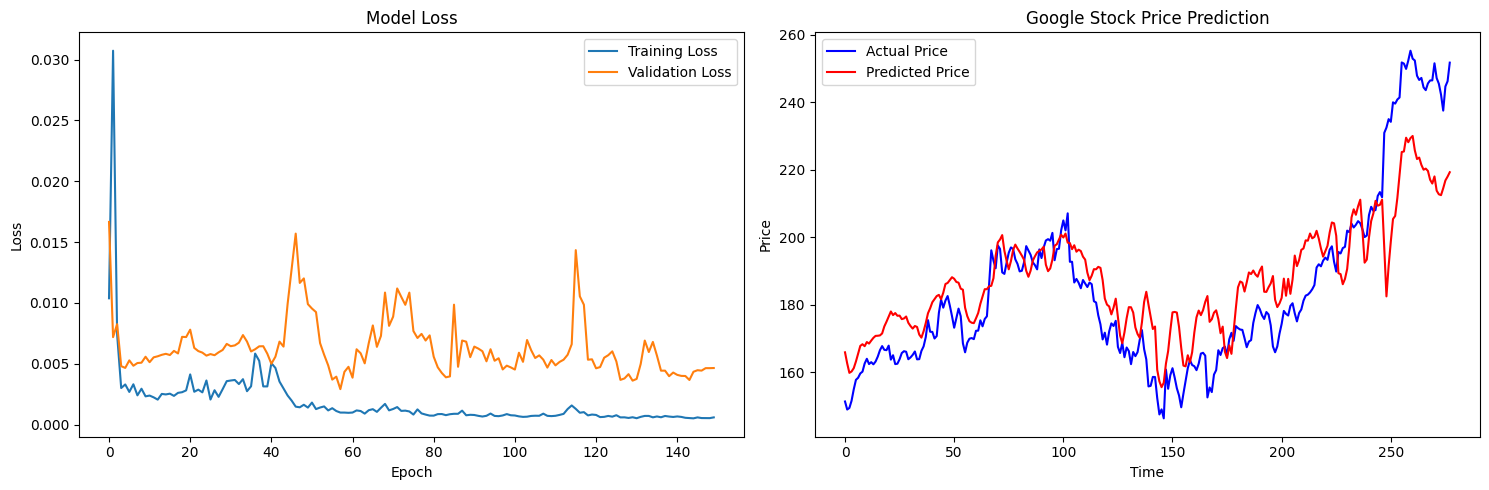


Метрики качества:
RMSE: 13.83


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

data = tmp_data_checkpoint.copy()

def prepare_data(data, lookback=30):
    features_to_scale = [col for col in data.columns if col != 'goog_average_score' and col != 'date']
    data_to_scale = data[features_to_scale].values

    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data_to_scale)

    data_score = data['goog_average_score'].values.reshape(-1, 1)
    min_rows = min(len(data_scaled), len(data_score))
    data_combined = np.hstack((data_scaled[:min_rows], data_score[:min_rows]))

    X, y = [], []
    for i in range(lookback, len(data_combined)):
        X.append(data_combined[i-lookback:i, :])
        y.append(data_combined[i, 0])

    X, y = np.array(X), np.array(y)

    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    return X_train, X_test, y_train, y_test, scaler

def create_model(lookback, n_features):
    model = Sequential()

    model.add(LSTM(units=50, return_sequences=True, input_shape=(lookback, n_features)))
    model.add(Dropout(0.2))

    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(units=1))

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='mean_squared_error',
                  metrics=['mae'])

    return model

def train_model(model, X_train, y_train, X_test, y_test):
    history = model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=150,
        validation_data=(X_test, y_test),
        verbose=1,
        shuffle=False
    )
    return history

def plot_results(history, model, X_test, y_test, scaler):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    predictions = model.predict(X_test)

    num_features_scaled = scaler.n_features_in_
    dummy_features = np.zeros((predictions.shape[0], num_features_scaled - 1))

    predictions_combined = np.hstack((predictions, dummy_features))
    predictions_original_scale = scaler.inverse_transform(predictions_combined)[:, 0]

    y_test_reshaped = y_test.reshape(-1, 1)
    dummy_features_y = np.zeros_like(dummy_features)
    y_test_combined = np.hstack((y_test_reshaped, dummy_features_y))
    y_test_original_scale = scaler.inverse_transform(y_test_combined)[:, 0]


    plt.subplot(1, 2, 2)
    plt.plot(y_test_original_scale, color='blue', label='Actual Price')
    plt.plot(predictions_original_scale, color='red', label='Predicted Price')
    plt.title('Google Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return predictions_original_scale, y_test_original_scale


LOOKBACK = 30

print("Загрузка данных...")
print(f"Загружено {len(data)} записей")

print("Подготовка данных...")
X_train, X_test, y_train, y_test, scaler = prepare_data(data, LOOKBACK)
print(f"Размер train X: {X_train.shape}")
print(f"Размер train y: {y_train.shape}")
print(f"Размер test X: {X_test.shape}")
print(f"Размер test y: {y_test.shape}")

print("Создание модели...")
n_features = X_train.shape[2]
model = create_model(LOOKBACK, n_features)
print(model.summary())

print("Обучение модели...")
history = train_model(model, X_train, y_train, X_test, y_test)

print("Визуализация результатов...")
predictions, actual = plot_results(history, model, X_test, y_test, scaler)

mse = mean_squared_error(actual, predictions)
rmse = np.sqrt(mse)

print(f"\nМетрики качества:")
print(f"RMSE: {rmse:.2f}")

In [26]:
data = tmp_data_checkpoint.copy()

In [27]:
def predict_future(model, data, scaler, lookback=5, n_future=7):
    features_to_scale = [col for col in data.columns if col != 'goog_average_score' and col != 'date']
    data_to_scale = data[features_to_scale].values
    data_score = data['goog_average_score'].values.reshape(-1, 1)

    data_scaled = scaler.transform(data_to_scale)
    data_combined = np.hstack((data_scaled, data_score))

    last_sequence = data_combined[-lookback:].copy()

    last_date = pd.to_datetime(data['date'].iloc[-1])
    future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=n_future)

    future_sentiments = []
    for d in future_dates:
        row = data[data['date'] == d]
        if not row.empty:
            future_sentiments.append(row['goog_average_score'].values[0])
        else:
            future_sentiments.append(data['goog_average_score'].iloc[-1])

    predictions_scaled = []
    current_seq = last_sequence.copy()

    for i in range(n_future):
        X_input = np.array([current_seq])
        next_pred_scaled = model.predict(X_input, verbose=0)[0][0]

        next_row = current_seq[-1, :].copy()
        next_row[0] = next_pred_scaled
        next_row[-1] = future_sentiments[i]
        current_seq = np.vstack((current_seq[1:], next_row))

        predictions_scaled.append(next_pred_scaled)

    predictions_scaled = np.array(predictions_scaled).reshape(-1, 1)
    dummy = np.zeros((n_future, scaler.n_features_in_ - 1))
    inv_scaled = scaler.inverse_transform(np.hstack((predictions_scaled, dummy)))
    predictions = inv_scaled[:, 0]

    forecast_df = pd.DataFrame({
        'date': future_dates,
        'predicted_avg_price_goog': predictions
    })

    return forecast_df

n_future_days = 7
future_forecast = predict_future(model, data, scaler, lookback=30, n_future=n_future_days)

print(future_forecast)

        date  predicted_avg_price_goog
0 2025-10-16                218.575350
1 2025-10-17                215.724500
2 2025-10-18                212.672116
3 2025-10-19                210.081838
4 2025-10-20                208.101910
5 2025-10-21                206.765848
6 2025-10-22                205.965216


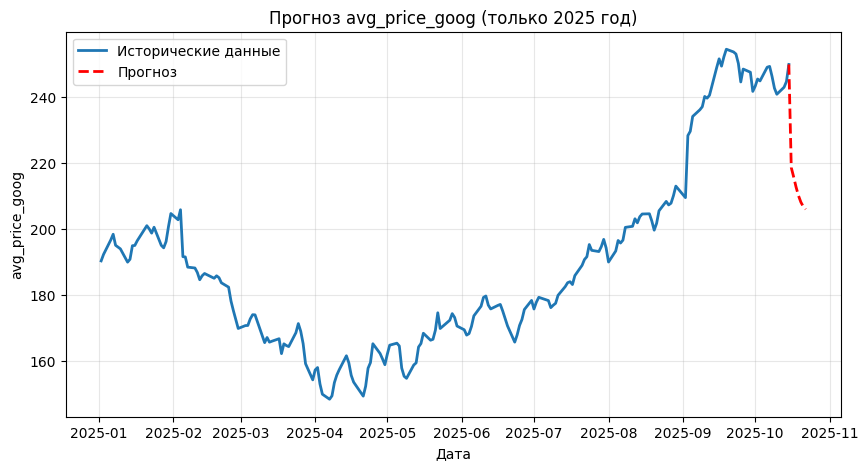

In [ ]:
data_2025 = data[(data['date'].dt.year == 2025)]
future_2025 = future_forecast[(future_forecast['date'].dt.year == 2025)]

last_historical_date = data_2025['date'].max()
last_historical_value = data_2025[data_2025['date'] == last_historical_date]['avg_price_goog'].values[0]

connection_point = pd.DataFrame({
    'date': [last_historical_date],
    'predicted_avg_price_goog': [last_historical_value]
})

continuous_forecast = pd.concat([connection_point, future_2025])

plt.figure(figsize=(10,5))
plt.plot(data_2025['date'], data_2025['avg_price_goog'], label='Исторические данные', linewidth=2)
plt.plot(continuous_forecast['date'], continuous_forecast['predicted_avg_price_goog'], 'r--', label='Прогноз', linewidth=2)

plt.title('Прогноз avg_price_goog (только 2025 год)')
plt.xlabel('Дата')
plt.ylabel('avg_price_goog')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [29]:
future_forecast[['date', 'predicted_avg_price_goog']].to_csv('./csv/predicted_prices.csv', mode='w', header=True)

In [31]:
pd.read_csv('./csv/predicted_prices.csv')

,Unnamed: 0,date,predicted_avg_price_goog
0,0,2025-10-16,218.575350
1,1,2025-10-17,215.724500
2,2,2025-10-18,212.672116
3,3,2025-10-19,210.081838
4,4,2025-10-20,208.101910
5,5,2025-10-21,206.765848
6,6,2025-10-22,205.965216
